# Calculate diversity statistics (π) and Tajima's D for H5N1 within-host data

September 13, 2019 

We would like to generate estimates of gene-wise πN and πS values to test for selection across coding regions. To determine whether the excess of low-frequency variation we observe could be due to demographic factors (population expansion), I would also like to calculate Tajima's D. This notebook includes code for setting up and running SNPGenie for calculating πN and πS, and code for manually calculating Tajima's D using those results for πN and πS, and manually counting and correcting S (segregating sites). Details describing the equations used for Tajima's D are shown in the markdown snippets below. 

### πN and πS
Chase Nelson's program, SNPGenie (https://github.com/chasewnelson/snpgenie) was written to calculate diversity statistics (like π and divergence) on within-host viral data. It takes as input gtf files and vcf files and will output a series of statistics. This software package is nice because the vcf input allows the user to pre-filter variants before inclusion in the diversity estimation. As with all other analyses in this paper, I am using SNPs called at a minimum frequency of 1%. Details for how π values are calculated are detailed on the SNPGenie github page (https://github.com/chasewnelson/snpgenie). 

There are a few quirks with SNPGenie that need to be worked out: 

1. SNPGenie only works on 1 gene segment at a time, so to run it on the full influenza genome, it needs to be run 8 separate times. For each genome, you need to provide a vcf that contains only sites from that gene, a gtf file with only coordinates for that cds, and a reference fasta with only that sequence. 

2. The vcf format options provided are quite close to what I need, but not quite. Varscan output is almost exactly the same as vcf option 4. The only difference is that SNPGenie assumes AD (allele depth) to be the number of reads supporting the reference base, when in varscan, it supports the number of reads for the alternative allele. Additionally, instead of having the reference base reads in 1 column and the alternative allele reads in another, SNPGenie would like them in the same column, separate by a comma. 

3. SNPGenie will not over-write old folders. So if I want everything in 1 folder, I will need to make new names for them as we proceed.

The code below deals with these issues and then runs the analysis on our data. 

### Tajima's D 
Tajima's D is calculated as the difference between 2 population genetics estimates of diversity (θ), π and S. π represents the average number of pairwise differences between a set of DNA sequences, and S is a count of the number of segregating sites in a set of DNA sequences. These measurements differ in that S is not affected by the frequency of variants, while π directly takes this into consideration. From wikipedia, the formula for Tajima's D is: 

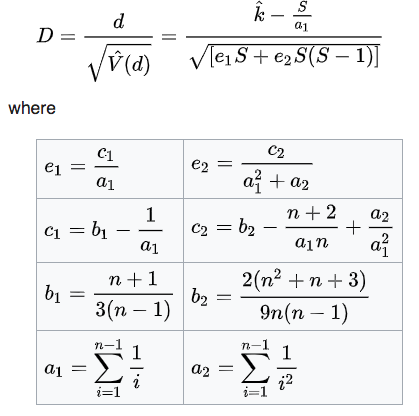

where k-hat is π, a is a correction for the sampled population size, and b,c, and e values are part of the calculation for the variance estimate that forms the denominator for D. For these calculations, I will use the mean coverage across the coding region as the estimate for n (population sample size), or for the full genome estimate, the mean coverage across all coding regions added together. 

In [1]:
# import necessary modules
import sys, subprocess, glob, os, shutil, re, importlib, Bio, csv
from subprocess import call
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats


import rpy2
%load_ext rpy2.ipython

In [2]:
# define colors 
human_color = "#C75643"
duck_color = "#545AB7"

duck_nonsyn_color = "#545AB7"
duck_syn_color = "#98B4DA"
human_nonsyn_color = "#C75643"
human_syn_color = "#E6B692"

# Calculate π with SNPGenie

In [3]:
# set working directory
directory = "/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/SNPGenie_diversity_estimates/1-percent-SNPs-2019-08-22/"

## 1. Fix AD column issue and split vcf by gene

In [4]:
# make a function to combine the AD column for vcf files

def format_vcfs_for_snpgenie(vcf_file):
    with open(vcf_file, "rU") as csvfile:
        reader = csv.reader(csvfile, delimiter="\t")
        
        # get a list of the genes that have SNPs in the original, combined vcf file
        genes = []
        for row in reader: 
            if "#" not in row[0] and "##" not in row[0]:
                gene = row[0]
                
                if gene.split("_")[-1:] == ['MP']:
                    genes.append(gene.replace("MP","M1"))
                    genes.append(gene.replace("MP","M2"))
                if gene.split("_")[-1:] == ['NS']:
                    genes.append(gene.replace("NS","NS1"))
                    genes.append(gene.replace("NS","NEP"))
                else:
                    genes.append(gene)
        genes = set(genes)
        
        # for each unique gene, make an empty output file with that gene as its name
        for i in genes:
            with open(directory + i + ".vcf", "w") as outfile:
                outfile.write("")
                
    # re-open and re-loop through            
    with open(vcf_file, "rU") as infile:
        for line in infile:
            # if it is a comment line, write it out to all of the output files
            if "#" in line or "##" in line:
                for i in genes:
                    with open(directory + i + ".vcf", "a") as outfile:
                        outfile.write(line)
            
            # if it's a SNP line, add in the AD annotation and write out to the appropriate file
            else: 
                gene = line.split("\t")[0]
                fix = line.split("\t")[9]
                ref_reads = fix.split(":")[4]
                alt_reads = fix.split(":")[5]
                new_depth = ref_reads + "," + alt_reads
                first_part = fix.split(":")[0:5]
                first_part = ":".join(first_part)
                second_part = fix.split(":")[6:14]
                second_part = ":".join(second_part)
                fixed = first_part + ":" + new_depth + ":" + second_part
                
                # combine into a new line
                new_line = line.replace(fix, fixed)
                
                if gene.split("_")[-1:] == ['MP']:
                    with open(directory + gene.replace("MP","M1") + ".vcf", "a") as outfile:
                        outfile.write(new_line)
                    with open(directory + gene.replace("MP","M2") + ".vcf", "a") as outfile:
                        outfile.write(new_line)
                        
                elif gene.split("_")[-1:] == ['NS']:
                    with open(directory + gene.replace("NS","NS1") + ".vcf", "a") as outfile:
                        outfile.write(new_line)
                    with open(directory + gene.replace("NS","NEP") + ".vcf", "a") as outfile:
                        outfile.write(new_line)
                  
                else:
                    with open(directory + gene + ".vcf", "a") as outfile:
                        outfile.write(new_line)


In [6]:
# generate a vcf file list of all the files that need to be reformatted

vcfs = []
vcf_directory = directory + "original-vcfs/"

for f in glob.glob(vcf_directory + "*.vcf"):
    vcfs.append(f)

In [7]:
# run the vcf format function
for vcf in vcfs: 
    vcf_file = vcf
    format_vcfs_for_snpgenie(vcf_file)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: 'U' mode is deprecated


## Split gtfs and fastas by gene

In [5]:
def split_fasta_files(fastas):
    # split up fasta files

    for fasta in fastas:
        with open(fasta, "r") as infile: 
            for seq in SeqIO.parse(infile, "fasta"):
                name = seq.description
                sequence = str(seq.seq)

                if name.endswith("MP"):
                    with open(directory + name.replace("MP","M1") + ".fasta", "w") as outfile:
                        outfile.write(">" + name.replace("MP","M1") + "\n")
                        outfile.write(sequence) 
                    with open(directory + name.replace("MP","M2") + ".fasta", "w") as outfile:
                        outfile.write(">" + name.replace("MP","M2") + "\n")
                        outfile.write(sequence)              

                elif name.endswith("NS"):
                    with open(directory + name.replace("NS","NS1") + ".fasta", "w") as outfile:
                        outfile.write(">" + name.replace("NS","NS1") + "\n")
                        outfile.write(sequence) 
                    with open(directory + name.replace("NS","NEP") + ".fasta", "w") as outfile:
                        outfile.write(">" + name.replace("NS","NEP") + "\n")
                        outfile.write(sequence) 

                else:
                    with open(directory + name + ".fasta", "w") as outfile:
                        outfile.write(">" + name + "\n")
                        outfile.write(sequence) 

In [6]:
def split_gtf_files(gtfs):
    # split up gtf files 

    for gtf in gtfs: 
        with open(gtf, "r") as infile:
            for line in infile:
                gene = line.split("\t")[0]

                if gene.endswith("MP") and "\"M1\"" in line:
                    with open(directory + gene.replace("MP","M1") + ".gtf", "a") as outfile:
                            outfile.write(line)

                elif gene.endswith("MP") and "\"M2\"" in line:
                    with open(directory + gene.replace("MP","M2") + ".gtf", "a") as outfile:
                        outfile.write(line)

                elif gene.endswith("NS") and "\"NS1\"" in line:
                    with open(directory + gene.replace("NS","NS1") + ".gtf", "a") as outfile:
                        outfile.write(line)

                elif gene.endswith("NS") and "\"NEP\"" in line:
                    with open(directory + gene.replace("NS","NEP") + ".gtf", "a") as outfile:
                        outfile.write(line)

                else:
                    with open(directory + gene + ".gtf", "a") as outfile:
                        outfile.write(line)

In [24]:
fastas = []
fastas_directory = directory + "gtfs-and-fastas/"
for f in glob.glob(fastas_directory + "*/sequences.fa"):
    fastas.append(f)
    
split_fasta_files(fastas)

In [25]:
gtfs = []
gtf_directory = directory + "gtfs-and-fastas/"
for f in glob.glob(gtf_directory + "*/genes.gtf"):
    gtfs.append(f)
    
split_gtf_files(gtfs)

### Consolidate files together into folders by sample name

In [26]:
# make a list of file names, which are just the gene names that the gtf file, fasta file and vcf files share
file_list = []
for f in glob.glob(directory + "*.vcf"):
    f = f.replace(".vcf","")
    file_list.append(f)

In [27]:
# consolidate fastas, vcfs, and gtfs all into 1 folder together 
for f in file_list:
    call("mkdir {f}".format(f=f), shell=True)
    for n in glob.glob(directory + "*"):
        if f in n:
            call("mv {n} {f}".format(n=n,f=f), shell=True)

#### Note: 

At this point, there will be gtf and fasta files for genes that are not in folders. That is ok. That means that there were no SNPs called for that gene in that sample. 

In [28]:
# run SNP Genie on all of these
for f in file_list:
    f1 = f.replace(directory, "")
    call("snpgenie.pl --vcfformat=4 --gtffile={f}/{f1}.gtf --fastafile={f}/{f1}.fasta --snpreport={f}/{f1}.vcf".format(f=f,f1=f1),shell=True)
    call("mv SNPGenie_Results {f}/".format(f=f,f1=f1), shell=True)

In [352]:
# compile all of the output files from the various genes
call("grep -i '' */SNPGenie_Results/product_results.txt >> combined.txt".format(directory=directory),shell=True)

0

In [436]:
# take out all of the unwanted lines from the combined file
def cleanup_snpgenie_output(directory, infile):
    with open(directory + infile, "r") as infile: 
        linenumber = 0
        for line in infile:
            linenumber += 1
            if linenumber == 1:
                new_line = line.split(":")[1]
                with open(directory + "combined_pi_formatted.txt", "a") as outfile:
                    outfile.write(new_line)
        
            elif "N_diffs" not in line:
                new_line = line.replace("/SNPGenie_Results/product_results.txt:temp_vcf4_Sample1.vcf","")
            
                genes = ["_PB2","_PB1","_PA","_H5","_NP","_N1","_M1","_M2","_NS1","_NEP"]
                for g in genes: 
                    if g + "\t" in new_line:
                        new_line2 = new_line.replace(g, "")
                with open(directory + "combined_pi_formatted.txt", "a") as outfile:
                    outfile.write(new_line2)

In [31]:
cleanup_snpgenie_output(directory, "combined.txt")

## Results:

This actually all worked really well! Except for the grep, which for some reason works totally fine in shell but isn't working for me when run from within this notebook. Otherwise though, things look good! I will now go through and see which genes didn't work/have empty values. 

## Samples without SNPs

I now need to acquire the nonsynonymous and synonymous sites for the samples without SNVs. To do this, I just generated a dummy vcf with a single SNV at site 30 in it that I will run on all the samples without SNVs. I picked site 30, because that is a site that is within all coding regions. I will then just pull out the nonsynonymous and synonymous length information. 

In [469]:
samples_no_snps_directory = "/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/SNPGenie_diversity_estimates/1-percent-SNPs-2019-08-22/samples-without-snps/"

# consolidate fastas, vcfs, and gtfs all into 1 folder together 
for f in glob.glob(samples_no_snps_directory + "*.gtf"):
    filename_base = f.replace(".gtf","")
    call("mkdir {filename_base}".format(filename_base=filename_base), shell=True)
    
    vcf_file = samples_no_snps_directory + "sample.vcf"
    fasta_file = f.replace(".gtf",".fasta")
    
    call("cp {vcf_file} {filename_base}".format(vcf_file=vcf_file,filename_base=filename_base), shell=True)
    call("cp {fasta_file} {filename_base}".format(fasta_file=fasta_file,filename_base=filename_base), shell=True)
    call("cp {f} {filename_base}".format(f=f,filename_base=filename_base), shell=True)

In [527]:
# run SNPgenie
for f in glob.glob(samples_no_snps_directory + "*.gtf"):
    filename_base = f.replace(samples_no_snps_directory, "").replace(".gtf","")
    call("snpgenie.pl --vcfformat=4 --gtffile={samples_no_snps_directory}/{filename_base}/{filename_base}.gtf --fastafile={samples_no_snps_directory}/{filename_base}/{filename_base}.fasta --snpreport={samples_no_snps_directory}/{filename_base}/sample.vcf".format(filename_base=filename_base,samples_no_snps_directory=samples_no_snps_directory),shell=True)
    call("mv SNPGenie_Results {samples_no_snps_directory}/{filename_base}/".format(filename_base=filename_base,samples_no_snps_directory=samples_no_snps_directory), shell=True)

In [ ]:
# run in shell
# compile all of the output files from the various genes
grep -i '' */SNPGenie_Results/product_results.txt >> combined.txt

In [528]:
cleanup_snpgenie_output(samples_no_snps_directory, "combined.txt")

In [547]:
# read in as dataframe
no_snps_df = pd.read_table(samples_no_snps_directory + "combined_pi_formatted.txt", sep="\t")
no_snps_df['product'] = no_snps_df['product'].fillna('neuram')                                     # replace NA with neuram
no_snps_df['species'] = np.where((no_snps_df['file'].str.contains("duck")), "duck","human")        # add in a species column
no_snps_df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,file,product,N_diffs,S_diffs,N_diffs_vs_ref,S_diffs_vs_ref,N_sites,S_sites,piN,piS,mean_dN_vs_ref,mean_dS_vs_ref,mean_gdiv_polymorphic,mean_N_gdiv,mean_S_gdiv,species
0,AH7E5L724F516_A_duck_Cambodia_Y0224304_2014,M1,0.136298,0.0,0.073171,0.000000,578.451220,177.548780,0.000236,0.0,0.000126,0.000000,0.135633551457466,0.135633551457466,*,duck
1,AH7E5L724F516_A_duck_Cambodia_Y0224304_2014,M2,0.136298,0.0,0.073171,0.000000,226.951220,64.048780,0.000601,0.0,0.000322,0.000000,0.135633551457466,0.135633551457466,*,duck
2,AH7E5L724F516_A_duck_Cambodia_Y0224304_2014,neuram,0.136298,0.0,0.073171,0.000000,1049.333333,297.666667,0.000130,0.0,0.000070,0.000000,0.135633551457466,0.135633551457466,*,duck
3,AH7E5L724F516_A_duck_Cambodia_Y0224304_2014,NEP,0.136298,0.0,0.000000,0.073171,287.666667,75.333333,0.000474,0.0,0.000000,0.000971,0.135633551457466,0.135633551457466,*,duck
4,AH7E5L724F516_A_duck_Cambodia_Y0224304_2014,NS1,0.136298,0.0,0.000000,0.073171,517.500000,157.500000,0.000263,0.0,0.000000,0.000465,0.135633551457466,0.135633551457466,*,duck


## Data wrangling and plotting:

In [556]:
# read in the SNPGenie pi results as a dataframe
df = pd.read_table(directory + "combined_pi_formatted.txt", sep="\t")
df['product'] = df['product'].fillna('neuram')                                     # replace NA with neuram
df['species'] = np.where((df['file'].str.contains("duck")), "duck","human")        # add in a species column
df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,file,product,N_diffs,S_diffs,N_diffs_vs_ref,S_diffs_vs_ref,N_sites,S_sites,piN,piS,mean_dN_vs_ref,mean_dS_vs_ref,mean_gdiv_polymorphic,mean_N_gdiv,mean_S_gdiv,species
0,AA4KNL706F512_A_Cambodia_X0128304_2013,HA,1.767124,0.223554,0.873365,0.116171,1332.740397,370.650907,0.001326,0.000603,0.000655,0.000313,0.198084954560712,0.251180976713173,0.0741942362049676,human
1,AA4KNL706F512_A_Cambodia_X0128304_2013,M1,0.350853,0.208944,0.185506,0.110311,578.515594,177.484406,0.000606,0.001177,0.000321,0.000622,0.0929131325381493,0.0872814044904492,0.104176588633549,human
2,AA4KNL706F512_A_Cambodia_X0128304_2013,M2,0.095517,0.000000,0.050139,0.000000,227.000000,64.000000,0.000421,0.000000,0.000221,0.000000,0.095250657583352,0.095250657583352,*,human
3,AA4KNL706F512_A_Cambodia_X0128304_2013,neuram,0.137856,0.215735,0.071550,0.115099,1050.119423,296.880577,0.000131,0.000727,0.000068,0.000388,0.08812925082461,0.0687268855488714,0.107531616100349,human
4,AA4KNL706F512_A_Cambodia_X0128304_2013,NEP,0.058154,0.000000,0.029891,0.000000,286.009964,76.990036,0.000203,0.000000,0.000105,0.000000,0.0579956285444234,0.0579956285444234,*,human


## Generate a full genome diversity estimate for each sample 

Generate a full genome estimate by taking weighted average of all the genes together.

From the genome of A/Vietnam/12032/004 from this set of Genbank numbers (AY818144), these are the lengths of the genes in the genome, and their proportion of the genome: 

PB2: 2289 = 0.172

PB1: 2274 = 0.170

PA: 2151 = 0.161

HA: 1707 = 0.128

NP: 1507 = 0.113

NA: 1350 = 0.101

M1: 759 = 0.057

M2: 294 = 0.022

NS1: 648  = 0.049

NEP: 366 = 0.027

Total: 13,345 = 1.0

In [557]:
gene_proportions_dict = {"PB2":0.172, "PB1":0.170,"PA":0.161, "HA":0.128,"NP":0.113,
                        "neuram":0.101,"M1":"0.057","M2":0.022,"NS1":0.049,"NEP":0.027}

In [558]:
full_genomes_df = pd.DataFrame()

for sample in set(df['file'].tolist()):
    
    full_genome_piN = 0
    full_genome_piS = 0
    
    for gene in set(df['product'].tolist()):
        local_df = df[(df['file'] == sample) & (df['product'] == gene)]
                
        if len(local_df) == 0:
            gene_piN = 0.0
            gene_piS = 0.0
        
        else:
            species = local_df['species'].item()
            gene_piN = float(local_df['piN'])
            gene_piS = float(local_df['piS'])
        
        weight = float(gene_proportions_dict[gene])
            
        full_genome_piN += (gene_piN * weight)
        full_genome_piS += (gene_piS * weight)
    
    to_add_df = pd.DataFrame.from_dict({"file":[sample],"product":['full\ngenome'],"N_diffs":["NA"],"S_diffs":["NA"],
                                        "N_diffs_vs_ref":["NA"],"S_diffs_vs_ref":["NA"],"N_sites":["NA"],"S_sites":["NA"],
                                        "piN":[full_genome_piN],"piS":[full_genome_piS],
                                        "mean_dN_vs_ref":["NA"],"mean_dS_vs_ref":["NA"],
                                        "mean_gdiv_polymorphic":["NA"],"mean_N_gdiv":["NA"],
                                        "mean_S_gdiv":["NA"],"species":[species]})
    
    full_genomes_df = full_genomes_df.append(to_add_df)

In [559]:
df = df.append(full_genomes_df)
df.head()

,file,product,N_diffs,S_diffs,N_diffs_vs_ref,S_diffs_vs_ref,N_sites,S_sites,piN,piS,mean_dN_vs_ref,mean_dS_vs_ref,mean_gdiv_polymorphic,mean_N_gdiv,mean_S_gdiv,species
0,AA4KNL706F512_A_Cambodia_X0128304_2013,HA,1.76712,0.223554,0.873365,0.116171,1332.74,370.651,0.001326,0.000603,0.000655315,0.000313423,0.198084954560712,0.251180976713173,0.0741942362049676,human
1,AA4KNL706F512_A_Cambodia_X0128304_2013,M1,0.350853,0.208944,0.185506,0.110311,578.516,177.484,0.000606,0.001177,0.000320659,0.000621526,0.0929131325381493,0.0872814044904492,0.104176588633549,human
2,AA4KNL706F512_A_Cambodia_X0128304_2013,M2,0.0955167,0,0.0501393,0,227,64,0.000421,0.000000,0.000220878,0,0.095250657583352,0.095250657583352,*,human
3,AA4KNL706F512_A_Cambodia_X0128304_2013,neuram,0.137856,0.215735,0.0715497,0.115099,1050.12,296.881,0.000131,0.000727,6.81348e-05,0.000387694,0.08812925082461,0.0687268855488714,0.107531616100349,human
4,AA4KNL706F512_A_Cambodia_X0128304_2013,NEP,0.0581537,0,0.0298913,0,286.01,76.99,0.000203,0.000000,0.000104511,0,0.0579956285444234,0.0579956285444234,*,human


## Perform bootstrapping analysis on diversity values

I had initially plotted mean diversity estimates per gene with error bars representing the standard deviation. This made sense to me, because I thought it would be useful to represent how much variability there was among samples (a lot). However, because variation was so significant among samples, one of our reviewer rightlyl noted that our error bars crossed 0 into negative diversity values, which doesn't make sense. To remedy this and make the visualization clearer, we settled on bootstrapping our results instead. This bootstrap is implemented as follows: 

1. For each gene and host species, resample πN or πS values, with replacement. For humans, resample 8 (since there are 8 human samples). For ducks, resample 5. 

2. Using this resampled dataset, calculate the mean πN or πS value. 

3. Repeat this process 10,000 times, separately for πN and πS, generating a dataset for each of 10,000 resampled datasets. 

4. Calculate the 5% and 95% quantile for this set of resampled datasets means. These will become our error bars. 

5. Repeat for each host and gene. 

In [279]:
def fill_in_missing_values(pi_values,sampling_value):
    missing_values = sampling_value - len(pi_values)
    
    for i in range(missing_values):
        pi_values.append(0.0)
    return(pi_values)

In [280]:
def bootrap_pi_values(pi_values, iterations, sampling_value):
    bootstrapped_means = []
    
    for i in range(iterations):
        sample = np.random.choice(pi_values, sampling_value, replace=True)
        mean = np.asarray(sample).mean()
        bootstrapped_means.append(mean)
    
    bootstrapped_means_array = np.array(bootstrapped_means)
    a = np.quantile(bootstrapped_means_array, 0.975)
    b = np.quantile(bootstrapped_means_array, 0.025)
    c = np.std(bootstrapped_means_array)
    
    return(a,b,c)

In [281]:
iterations = 10000
sampling_values = {"human":8, "duck":5}
df1 = pd.DataFrame()

for species in set(df['species'].tolist()):
    
    for gene in set(df['product'].tolist()):
        for p in ["piN","piS"]:
            
            # add in exception for PB1, since we are missing 1 PB1 sequence 
            if gene == "PB1" and species == "human":
                sampling_value = 7
            else: 
                sampling_value = sampling_values[species]
            
            d = df[(df['product'] == gene) & (df['species'] == species)]
            values = d[p].tolist()
            
            pi_values = fill_in_missing_values(values,sampling_value)
            mean = np.asarray(pi_values).mean()
            a,b,c = bootrap_pi_values(pi_values, iterations, sampling_value)
            
            # generate dataframe 
            x = pd.DataFrame({"species":[species],"gene":[gene],"variable":[p],"mean":[mean],
                            "bootstrap_lower":[b],"bootstrap_upper":[a],"se_mean":[c]})
            df1 = df1.append(x)

In [282]:
df1.head()

,species,gene,variable,mean,bootstrap_lower,bootstrap_upper,se_mean
0,duck,M1,piN,0.000068,0.0,0.000144,0.000038
0,duck,M1,piS,0.000000,0.0,0.000000,0.000000
0,duck,M2,piN,0.000000,0.0,0.000000,0.000000
0,duck,M2,piS,0.000000,0.0,0.000000,0.000000
0,duck,PB2,piN,0.000000,0.0,0.000000,0.000000


In [283]:
df1['color'] = df1['species'] + " " + df1['variable'].str.replace("piN","nonsynonymous").replace("piS","synonymous")
df1

,species,gene,variable,mean,bootstrap_lower,bootstrap_upper,se_mean,color
0,duck,M1,piN,0.000068,0.000000,0.000144,0.000038,duck nonsynonymous
0,duck,M1,piS,0.000000,0.000000,0.000000,0.000000,duck synonymous
0,duck,M2,piN,0.000000,0.000000,0.000000,0.000000,duck nonsynonymous
0,duck,M2,piS,0.000000,0.000000,0.000000,0.000000,duck synonymous
0,duck,PB2,piN,0.000000,0.000000,0.000000,0.000000,duck nonsynonymous
0,duck,PB2,piS,0.000305,0.000000,0.000799,0.000215,duck synonymous
0,duck,NEP,piN,0.000030,0.000000,0.000091,0.000027,duck nonsynonymous
0,duck,NEP,piS,0.000129,0.000000,0.000388,0.000116,duck synonymous
0,duck,PA,piN,0.000037,0.000000,0.000110,0.000033,duck nonsynonymous
0,duck,PA,piS,0.000160,0.000028,0.000292,0.000067,duck synonymous


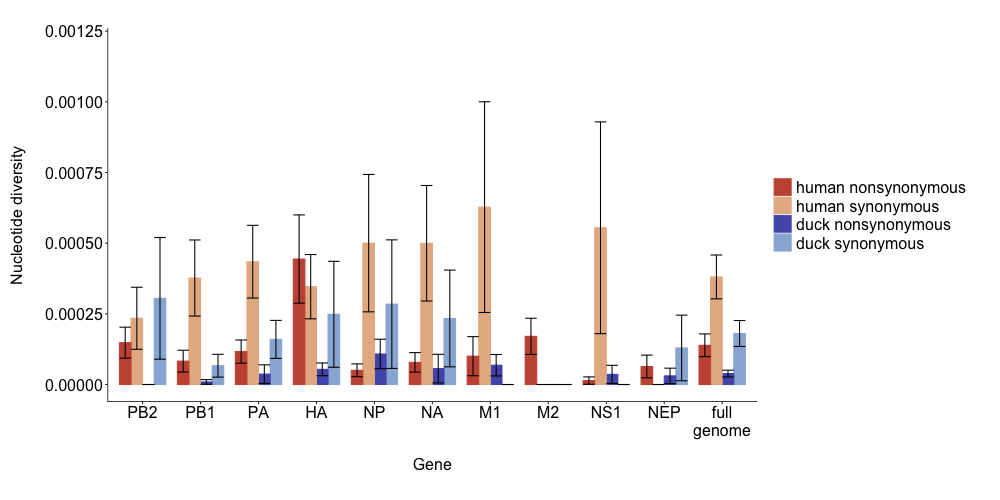

In [287]:
%%R -w 1000 -h 500 -u px -i  df1,human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)

# this block of code is to ensure that even genes without SNPs get plotted so that the bars are all the same size
species_list = unique(df1$species)
gene_list = unique(df1$gene)
variables_list = unique(df1$variable)

for (species in species_list)
{
    for (gene in gene_list)
    {
        for (variable in variables_list)
        {
            x = df1[df1$species == species & df1$gene == gene & df1$variable == variable,]
            if (nrow(x) == 0){
                mean = 0
                std = 0
                if (variable == "N_per_site"){
                    color = paste(species, "nonsynonymous")
                } else{
                    color = paste(species, "synonymous")
                }
                row_to_append = data.frame(gene, species, variable, mean, std, color)
                d = rbind(df, row_to_append)
            }
        }
    }
}

df1$gene = gsub("neuram","NA", df1$gene)
df1$colorf = factor(df1$color, levels=c("human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"))
df1$genef = factor(df1$gene, levels=c('PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP','full\ngenome'))

p <- ggplot(data=df1, aes(x=genef, y=mean, color=colorf, fill=colorf, width=0.8)) +
    geom_col(position="dodge")+   
    #geom_errorbar(data=df1, aes(x=genef, ymin=bootstrap_lower, ymax=bootstrap_upper), position="dodge", color="black")+
    geom_errorbar(data=df1, aes(x=genef, ymin=mean-se_mean, ymax=mean+se_mean), position="dodge", color="black")+
    labs(x="\nGene",y="Nucleotide diversity")+
    scale_color_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    scale_fill_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    #ggtitle("random tables simulation") + 
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #facet_wrap(~genef, scales="free")+
    scale_y_continuous(limits=c(0,0.0012))+
    theme(strip.text = element_text(size=16))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.65, "cm"))+
    #theme(legend.key=element_rect(fill=NA,size = 2))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("Fig-2-piN_piS-se-mean-2019-09-13.pdf", p, width = 14, height = 6, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/Plos-Pathogens/resubmission/individual-PDFs/")
p

## Compare piN and piS values with t-test

For each gene and species, compare the set of πN and πS values to each other, to test the null hypothesis that they will be equal (as predicted under neutrality). Do this using a paired t-test. 

In [288]:
df2 = pd.DataFrame()
sampling_values = {"human":8, "duck":5}

for species in set(df['species'].tolist()):
    
    for gene in set(df['product'].tolist()):
        d = df[(df['product'] == gene) & (df['species'] == species)]

        # add in exception for PB1, since we are missing 1 PB1 sequence 
        if gene == "PB1" and species == "human":
            sampling_value = 7
        else: 
            sampling_value = sampling_values[species]
        
        piN_values = list(d['piN'])
        piS_values = list(d['piS'])
        
        diff = sampling_value - len(d)
        for i in range(diff):
            piN_values.append(0.0)
            piS_values.append(0.0)
            
        ttest = stats.ttest_rel(piN_values, piS_values, axis=0)
        pvalue = ttest[1]

        x = pd.DataFrame({"species":[species],"gene":[gene],"pvalue":[pvalue]})
        df2 = df2.append(x)

In [289]:
df2

,species,gene,pvalue
0,duck,M1,0.181457
0,duck,M2,NaN
0,duck,PB2,0.272068
0,duck,NEP,0.373901
0,duck,PA,0.093587
0,duck,HA,0.396980
0,duck,NS1,0.373901
0,duck,full\ngenome,0.037678
0,duck,PB1,0.309139
0,duck,NP,0.491429


# Calculate Tajima's D

Tajima's D is a statistic used to summarize a site frequency spectrum, and is calculated as π - S / (square root of variance of π - S). Here, π is the average number of pairwise differences between you sequences, divided by sequence length (πN and πS in the SNPGenie output). S is the number of segregating sites, with a correction for the number of individuals being compared. So, S = S/a1, where a1 = the sum over 1 to n-1 of 1/i, as shown below. n is the number of individuals in your sample, or here, mean coverage across the coding region. S is then divided by sequence length to make it comparable to the π values. 

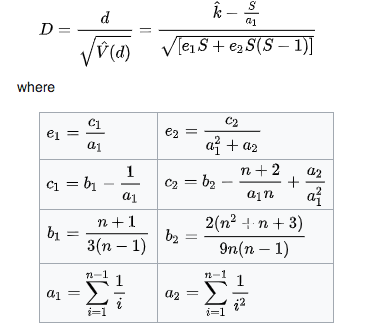

## Read in coverage values 

I am first calculating the mean coverage across each coding region for each sample, which I will then use as my n value (population sample size). 

In [3]:
import os.path
from os import path

"""Because not all samples have the same genome length, and they were not all mapped to the
same reference sequence, I need to define the coding regions separately for each sample.
In the SNPGenie folder, there already exists a gtf file for each gene, so I will use that 
to define coding regions and then calculate coverage across those sites."""

def define_coding_region(sample_id, gene):
    gtfs_directory = "/usr/local/bin/snpEff_latest_core/snpEff/data/"
    
    file_to_open = gtfs_directory + sample_id + "/genes.gtf"
    
    if path.exists(file_to_open):
        with open(file_to_open) as infile:
            start = []
            stop = []
            for line in infile: 
                if "CDS" in line and gene in line: 
                    start.append(int(line.split("\t")[3]))
                    stop.append(int(line.split("\t")[4]))
                    gene_id = line.split("\t")[8].split(";")[0].replace("gene_id \"","").replace("\"","")
                    
        return(start,stop)
    
    else: 
        return(0,0)

In [4]:
"""This function will take in a list of pileup files, and then iterate through each file.
Pileup files are organized such that each line corresponds to a single site in the genome, 
and is associated with an overall coverage value, and then the actual nucleotides present
at that site. I have noticed in the past that sometimes if there are 0 coverage sites 
at the beginning or ending of the gene, those sites will be omitted from the pileup file
rather than having a site with a coverage of 0. Because we want to find the total average
coverage across the coding region, we really want to count any sites with 0 coverage as a
0. The code at the very end of this function will take care of that. Additionally, for 
sites that lie within multiple coding regions (sites in NS and MP), we need to make sure 
to add those coverage values for both coding regions. We need to do this because I calculated
pi independently for each coding region. So, in total, this function will read in pileups,
query the coding regions for each gene and output a list with all the sites and their 
coverages."""

def generate_coverage_values(pileups):
    
    coverages = {}

    for p in pileups: 
        with open(p, "r") as infile: 

            for line in infile: 
                header = line.split("\t")[0]
                sample = "/".join(header.split("_")[1:-1])
                sample_id = "_".join(header.split("_")[:-1])
                site = int(line.split("\t")[1])
                coverage = int(line.split("\t")[3])
                
                # rename HA and NA, and split out MP and NS into M1/M2 and NS1/NEP 
                gene = "".join(header.split("_")[-1:])
                gene = gene.replace("N1","NA").replace("H5","HA")
                if gene == "MP":
                    genes_to_query = ["M1","M2"]
                elif gene == "NS":
                    genes_to_query = ["NS1","NEP"]
                else: 
                    genes_to_query = [gene]

                for g in genes_to_query:
                    # get the gene coordinates 
                    start,stop = define_coding_region(sample_id, g)
                
                    if sample not in coverages: 
                        coverages[sample] = {}
                    if g not in coverages[sample]:
                        coverages[sample][g] = []
                    if g in coverages[sample]:
                        for i in range(len(start)):
                            if site >= start[i] and site <= stop[i]: 
                                coverages[sample][g].append(coverage)
                        
                        
        # now fill in 0 coverage sites, just in case the pileup file doesn't have that in there
        for gene in coverages[sample]:
            coverage_length = len(coverages[sample][gene])
            start,stop = define_coding_region(sample_id, gene)
            cds_length = 0 
            for i in range(len(start)):
                cds_length += int(stop[i]) - int(start[i]) + 1
                
            difference = cds_length - coverage_length
            for i in range(difference):
                coverages[sample][gene].append(0)

    return(coverages)

In [5]:
"""Given a dictionary of samples with coverage lists, take the mean coverage per coding
region and per full genome."""

def return_coverage_means(coverages):
    coverage_means = {}
    
    for sample in coverages:
        coverage_means[sample] = {}
        full_genome_coverages = 0
        full_genome_length = 0
        
        for gene in coverages[sample]:            
            if len(coverages[sample][gene]) > 0:
                mean = float(sum(coverages[sample][gene]))/len(coverages[sample][gene])
                full_genome_coverages += sum(coverages[sample][gene])
                full_genome_length += len(coverages[sample][gene])
            else:
                mean = 0

            coverage_means[sample][gene] = mean
        
        # add in full genome measurment
        full_genome_mean = full_genome_coverages/full_genome_length
        coverage_means[sample]['full\ngenome'] = full_genome_mean
            
    return(coverage_means)

In [6]:
def generate_coverage_means_dataframe(coverage_means):
    df = pd.DataFrame.from_dict(coverage_means, orient="columns")
    return(df)

In [7]:
# read in pileup files
directory = "/Volumes/gradschool-and-postdoc-backups/post-doc/stored_files_too_big_for_laptop/H5N1_Cambodia_outbreak_study/Cambodia_H5_sequence_raw_data/combined_human_and_bird_usable_subset/"

pileups = []
for f in glob.glob(directory + "*/coverage_norm_and_duplicate_read_removal/*.nodups.sam.pileup"):
    pileups.append(f)
print(len(pileups))

13


In [8]:
# generate coverage means 
coverages = generate_coverage_values(pileups)
coverage_means = return_coverage_means(coverages)
coverage_means_df = generate_coverage_means_dataframe(coverage_means)
coverage_means_df.head()

,A/Cambodia/X0219301/2013,A/Cambodia/X1030304/2013,A/CAMBODIA/V0417301/2011,A/Cambodia/W0112303/2012,A/Cambodia/X0125302/2013,A/Cambodia/X0207301/2013,A/duck/Cambodia/381W11M4/2013,A/duck/Cambodia/PV027D1/2010,A/duck/Cambodia/083D1/2011,A/duck/Cambodia/Y0224301/2014,A/duck/Cambodia/Y0224304/2014,A/Cambodia/X0128304/2013,A/CAMBODIA/V0401301/2011
HA,81.374341,274.752783,175.719977,163.018161,80.453427,172.251904,221.918871,220.057996,244.888108,203.888108,213.377934,234.970709,186.628588
M1,331.649539,351.992095,330.151515,331.674572,361.175231,341.894598,263.931489,271.175231,280.586298,285.595520,311.998682,304.752306,328.113134
M2,265.261905,284.755102,265.197279,260.775510,297.353741,263.221088,238.013605,252.047619,267.285714,245.812925,302.064626,251.809524,269.295775
NA,322.184444,300.191852,306.342222,318.037037,323.909630,318.800741,213.525926,222.408148,275.793333,272.128889,242.591852,301.157778,311.654815
NEP,236.669399,293.016393,251.079235,245.587432,287.174863,223.734973,232.579235,220.448087,266.797814,262.120219,310.352459,287.046448,248.762295


## Generate correction for coverage, a1, and other values necessary for variance calculation

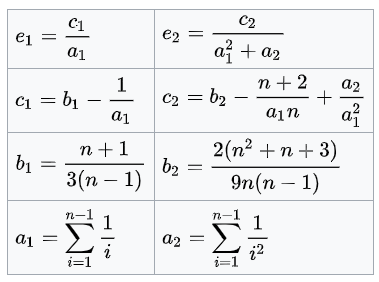

In [9]:
def calculate_a_values(mean_coverage):
    a1 = 0
    a2 = 0
    integer_value = round(mean_coverage)
    for i in range(1, integer_value):
        a1 += 1/i
        a2 += 1/(i**2)
    return(a1,a2)

In [10]:
def calculate_b_values(mean_coverage):
    integer_value = round(mean_coverage)
    b1 = (integer_value + 1)/(3*(integer_value - 1))
    b2 = (2*(integer_value**2 + integer_value + 3))/((9*integer_value)*(integer_value - 1))
    return(b1,b2)

In [11]:
def calculate_c_values(mean_coverage,a1,a2,b1,b2):
    integer_value = round(mean_coverage)
    c1 = b1 - (1/a1)
    c2 = b2 - ((integer_value + 2)/(a1*integer_value)) + (a2/(a1**2))
    return(c1,c2)

In [12]:
def calculate_e_values(a1,a2,c1,c2):
    e1 = c1/a1
    e2 = c2/((a1**2)+a2)
    return(e1,e2)

In [13]:
def return_all_corrections_values(mean_coverage):
    a1,a2 = calculate_a_values(mean_coverage)
    b1,b2 = calculate_b_values(mean_coverage)
    c1,c2 = calculate_c_values(mean_coverage,a1,a2,b1,b2)
    e1,e2 = calculate_e_values(a1,a2,c1,c2)
    
    return(a1,a2,b1,b2,c1,c2,e1,e2)

In [14]:
def generate_a_values_dict_and_df(coverage_means):
    a_values = {}

    for sample in coverage_means: 
        a_values[sample] = {}
        for gene in coverage_means[sample]:
            mean_coverage = float(coverage_means[sample][gene])
            a1,a2 = calculate_a_values(mean_coverage)
            a_values[sample][gene] = a1
            

    a_values_df = pd.DataFrame.from_dict(a_values, orient="index")
    a_values_df.reset_index(inplace=True)
    
    a_values_df2 = pd.melt(a_values_df, id_vars="index")
    a_values_df2.columns = ['sample',"gene","a_correction"]
    
    return(a_values, a_values_df, a_values_df2)

In [15]:
def generate_e_values_dict_and_df(coverage_means):
    e1_values = {}
    e2_values = {}

    for sample in coverage_means: 
        e1_values[sample] = {}
        e2_values[sample] = {}
        
        for gene in coverage_means[sample]:
            mean_coverage = float(coverage_means[sample][gene])
            if int(mean_coverage) > 0:
                a1,a2,b1,b2,c1,c2,e1,e2 = return_all_corrections_values(mean_coverage)
                e1_values[sample][gene] = e1
                e2_values[sample][gene] = e2
            else:
                e1_values[sample][gene] = 0
                e1_values[sample][gene] = 2

    e1_values_df = pd.DataFrame.from_dict(e1_values, orient="index")
    e2_values_df = pd.DataFrame.from_dict(e2_values, orient="index")
    e1_values_df.reset_index(inplace=True)
    e2_values_df.reset_index(inplace=True)
    
    e1_values_df2 = pd.melt(e1_values_df, id_vars="index")
    e2_values_df2 = pd.melt(e2_values_df, id_vars="index")
    e1_values_df2.columns = ['sample',"gene","e1"]
    e2_values_df2.columns = ['sample',"gene","e2"]
    
    e_values_df2 = e1_values_df2.merge(e2_values_df2, on=['sample','gene'])
    
    return(e_values_df2)

### Run functions, generate a1 correction and e values necessary for variance estimation

In [16]:
a_values,a_values_df,a_values_df2 = generate_a_values_dict_and_df(coverage_means)
a_values_df.head()

,index,HA,M1,M2,NA,NP,NS1,NEP,PA,PB1,PB2,full genome
0,A/CAMBODIA/V0401301/2011,5.805648,6.368704,6.170067,6.318615,6.315400,6.302434,6.092659,6.275986,6.248820,6.013119,6.188518
1,A/CAMBODIA/V0417301/2011,5.744856,6.374792,6.155058,6.299166,6.365646,6.302434,6.100675,6.401740,6.337694,6.234955,6.262495
2,A/Cambodia/W0112303/2012,5.667895,6.380844,6.139819,6.337694,6.350214,6.272630,6.080513,6.383856,6.305691,6.147467,6.231458
3,A/Cambodia/X0125302/2013,4.952979,6.464708,6.269263,6.356415,6.334539,6.401740,6.234955,6.334539,6.234955,6.021796,6.173785
4,A/Cambodia/X0128304/2013,6.034672,6.295887,6.104659,6.282664,6.181178,6.325015,6.234955,6.076432,NaN,6.096675,6.155058


In [17]:
a_values_df2.head()

,sample,gene,a_correction
0,A/CAMBODIA/V0401301/2011,HA,5.805648
1,A/CAMBODIA/V0417301/2011,HA,5.744856
2,A/Cambodia/W0112303/2012,HA,5.667895
3,A/Cambodia/X0125302/2013,HA,4.952979
4,A/Cambodia/X0128304/2013,HA,6.034672


In [18]:
e_values_df2 = generate_e_values_dict_and_df(coverage_means)
e_values_df2.head()

,sample,gene,e1,e2
0,A/CAMBODIA/V0401301/2011,HA,0.028364,0.002806
1,A/CAMBODIA/V0417301/2011,HA,0.028386,0.002841
2,A/Cambodia/W0112303/2012,HA,0.028408,0.002885
3,A/Cambodia/X0125302/2013,HA,0.028240,0.003346
4,A/Cambodia/X0128304/2013,HA,0.028249,0.002682


In [19]:
# merge a, e1, and e2 values together into 1 dataframe that can be combined with the pi and S data
corrections_df = a_values_df2.merge(e_values_df2, on=['sample','gene'])
corrections_df['gene'] = corrections_df['gene'].str.replace("NA","neuraminidase")
corrections_df.head()

,sample,gene,a_correction,e1,e2
0,A/CAMBODIA/V0401301/2011,HA,5.805648,0.028364,0.002806
1,A/CAMBODIA/V0417301/2011,HA,5.744856,0.028386,0.002841
2,A/Cambodia/W0112303/2012,HA,5.667895,0.028408,0.002885
3,A/Cambodia/X0125302/2013,HA,4.952979,0.028240,0.003346
4,A/Cambodia/X0128304/2013,HA,6.034672,0.028249,0.002682


## Read in and count the number of SNVs per gene, per sample 

In [20]:
def read_and_format_dataframe(snps_df):
    
    # reformat the sampleid 
    snps_df['sampleid'] = snps_df['sampleid'].str[14:]

    # get rid of the incorrect variant call due to a mismatched reference base
    snps_df = snps_df[snps_df['coding_region_change'] != 'Xaa240Gly']

    # change NAs to neuramindase
    snps_df['gene'].fillna('neuraminidase', inplace=True)
    
    return(snps_df)

In [21]:
def generate_SNV_counts_dataframe(snps_df):
    
    # count the number of SNPs per gene per sample and output as a dataframe
    counts = pd.DataFrame(snps_df.groupby(["sample", "gene","synonymous_nonsynonymous"]).size())
    counts.reset_index(inplace=True)
    counts.columns = ['sample','gene','synonymous_nonsynonymous','number_of_SNPs']
    
    # unmelt the synonymous nonsynonymous column
    counts = counts[counts['synonymous_nonsynonymous'] != 'stop_gained']   # remove stop gained
    counts = counts.pivot_table(index = ['sample','gene'], columns = 'synonymous_nonsynonymous', values='number_of_SNPs')
    counts.reset_index(inplace=True)
    counts = counts.fillna(0)
    
    # add in a species column
    counts['species'] = counts['sample'].str.contains("duck")
    counts['species'] = counts['species'].replace(True,"duck")
    counts['species'] = counts['species'].replace(False,"human")
    
    # rename columns
    counts.columns = ["sample","gene","nonsynonymous","synonymous","species"]

    return(counts)

In [22]:
def generate_full_genome_SNV_counts_dataframe(snps_df):
    
    # count the number of SNPs per gene per sample and output as a dataframe
    counts = pd.DataFrame(snps_df.groupby(["sample", "synonymous_nonsynonymous"]).size())
    counts.reset_index(inplace=True)
    counts.columns = ['sample','synonymous_nonsynonymous','number_of_SNPs']
    
    # unmelt the synonymous nonsynonymous column
    counts = counts[counts['synonymous_nonsynonymous'] != 'stop_gained']   # remove stop gained
    counts = counts.pivot_table(index = ['sample'], columns = 'synonymous_nonsynonymous', values='number_of_SNPs')
    counts.reset_index(inplace=True)
    counts = counts.fillna(0)
    
    # add in a species column
    counts['species'] = counts['sample'].str.contains("duck")
    counts['species'] = counts['species'].replace(True,"duck")
    counts['species'] = counts['species'].replace(False,"human")
    
    # add back gene column
    counts['gene'] = "full\ngenome"
    
    # reorder columns
    counts.columns = ["sample","nonsynonymous","synonymous","species","gene"]
    counts = counts[['sample','gene','nonsynonymous','synonymous','species']]

    return(counts)

In [23]:
# variant calls file to load in
variant_calls = "/Users/lmoncla/src/h5n1-cambodia/data/within-host-variants-1%.txt"

snps_df = pd.read_csv(variant_calls, sep='\t', header='infer')

snps_df = read_and_format_dataframe(snps_df)
snv_counts_df = generate_SNV_counts_dataframe(snps_df)
snv_counts_full_genome_df = generate_full_genome_SNV_counts_dataframe(snps_df)

snv_counts_df = snv_counts_df.append(snv_counts_full_genome_df)
snv_counts_df.head()

,sample,gene,nonsynonymous,synonymous,species
0,A/CAMBODIA/V0401301/2011,HA,12.0,1.0,human
1,A/CAMBODIA/V0401301/2011,M1,1.0,0.0,human
2,A/CAMBODIA/V0401301/2011,NP,4.0,2.0,human
3,A/CAMBODIA/V0401301/2011,PA,8.0,1.0,human
4,A/CAMBODIA/V0401301/2011,PB1,4.0,4.0,human


## Merge together and calculate S with a1 correction (S/a1) and variance

In [24]:
# add in a column for the correction factor 
snv_counts_with_correction_df = snv_counts_df.merge(corrections_df, how="left")
snv_counts_with_correction_df['S/a1_NS'] = snv_counts_with_correction_df['nonsynonymous']/snv_counts_with_correction_df['a_correction']
snv_counts_with_correction_df['S/a1_S'] = snv_counts_with_correction_df['synonymous']/snv_counts_with_correction_df['a_correction'] 
snv_counts_with_correction_df.head()

,sample,gene,nonsynonymous,synonymous,species,a_correction,e1,e2,S/a1_NS,S/a1_S
0,A/CAMBODIA/V0401301/2011,HA,12.0,1.0,human,5.805648,0.028364,0.002806,2.066953,0.172246
1,A/CAMBODIA/V0401301/2011,M1,1.0,0.0,human,6.368704,0.028005,0.002514,0.157018,0.000000
2,A/CAMBODIA/V0401301/2011,NP,4.0,2.0,human,6.315400,0.028049,0.002540,0.633372,0.316686
3,A/CAMBODIA/V0401301/2011,PA,8.0,1.0,human,6.275986,0.028081,0.002559,1.274700,0.159338
4,A/CAMBODIA/V0401301/2011,PB1,4.0,4.0,human,6.248820,0.028102,0.002572,0.640121,0.640121


### Calculate variance 

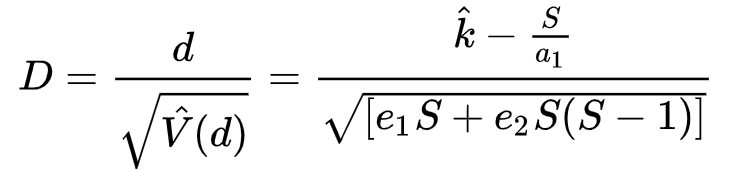

In [25]:
# add in variance
snv_counts_with_correction_df["variance_NS"] = np.sqrt((snv_counts_with_correction_df["e1"] * snv_counts_with_correction_df['nonsynonymous'])+(snv_counts_with_correction_df["e2"]*snv_counts_with_correction_df['nonsynonymous']*(snv_counts_with_correction_df['nonsynonymous']-1)))
snv_counts_with_correction_df["variance_S"] = np.sqrt((snv_counts_with_correction_df["e1"] * snv_counts_with_correction_df['synonymous'])+(snv_counts_with_correction_df["e2"]*snv_counts_with_correction_df['synonymous']*(snv_counts_with_correction_df['synonymous']-1)))

snv_counts_with_correction_df.head()

,sample,gene,nonsynonymous,synonymous,species,a_correction,e1,e2,S/a1_NS,S/a1_S,variance_NS,variance_S
0,A/CAMBODIA/V0401301/2011,HA,12.0,1.0,human,5.805648,0.028364,0.002806,2.066953,0.172246,0.843084,0.168416
1,A/CAMBODIA/V0401301/2011,M1,1.0,0.0,human,6.368704,0.028005,0.002514,0.157018,0.000000,0.167346,0.000000
2,A/CAMBODIA/V0401301/2011,NP,4.0,2.0,human,6.315400,0.028049,0.002540,0.633372,0.316686,0.377720,0.247341
3,A/CAMBODIA/V0401301/2011,PA,8.0,1.0,human,6.275986,0.028081,0.002559,1.274700,0.159338,0.606588,0.167572
4,A/CAMBODIA/V0401301/2011,PB1,4.0,4.0,human,6.248820,0.028102,0.002572,0.640121,0.640121,0.378518,0.378518


## Reread in π values and generate full genome N sites and S sites

I am first reading in the results I got from running SNPGenie on fake data. This dataframe, "no_snps_df" will have actual pi values in it, but those should be disregarded. I am only using this data to get the number of synonymous and nonsynonymous sites for those samples. The actual pi data, calculated from samples with SNPs, is in true_snps_df. 

In [26]:
samples_no_snps_directory = "/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/SNPGenie_diversity_estimates/1-percent-SNPs-2019-08-22/samples-without-snps/"
directory = "/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/SNPGenie_diversity_estimates/1-percent-SNPs-2019-08-22/"

In [27]:
# read in no snps dataframe so that I can use the N_sites and S_sites 
no_snps_df = pd.read_table(samples_no_snps_directory + "combined_pi_formatted.txt", sep="\t")
no_snps_df['product'] = no_snps_df['product'].fillna('neuram')                                     # replace NA with neuram
no_snps_df['species'] = np.where((no_snps_df['file'].str.contains("duck")), "duck","human")        # add in a species column
no_snps_df = no_snps_df.drop(["N_diffs","S_diffs","N_diffs_vs_ref","S_diffs_vs_ref","mean_dN_vs_ref","mean_dS_vs_ref","mean_gdiv_polymorphic","mean_N_gdiv","mean_S_gdiv"], axis=1)
# set these pi values to 0
no_snps_df['piN'] = 0
no_snps_df['piS'] = 0

# read in the SNPGenie pi results as a dataframe
true_snps_df = pd.read_table(directory + "combined_pi_formatted.txt", sep="\t")
true_snps_df['product'] = true_snps_df['product'].fillna('neuram')                                     # replace NA with neuram
true_snps_df['species'] = np.where((true_snps_df['file'].str.contains("duck")), "duck","human")        # add in a species column
true_snps_df = true_snps_df.drop(["N_diffs","S_diffs","N_diffs_vs_ref","S_diffs_vs_ref","mean_dN_vs_ref","mean_dS_vs_ref","mean_gdiv_polymorphic","mean_N_gdiv","mean_S_gdiv"], axis=1)

# read in pi data from above, clean up sample names, remove extraneous columns
pi_data = true_snps_df.append(no_snps_df)
pi_data['sample'] = pi_data['file'].str.split("_").str[1:].str.join("/")
pi_data = pi_data.drop("file", axis=1)
pi_data.columns = ['gene',"N_sites","S_sites","piN","piS","species","sample"]
pi_data['gene'] = pi_data['gene'].str.replace("neuram","neuraminidase")
pi_data.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: read_table is deprecated, use read_csv instead.
  # This is added back by InteractiveShellApp.init_path()


,gene,N_sites,S_sites,piN,piS,species,sample
0,HA,1332.740397,370.650907,0.001326,0.000603,human,A/Cambodia/X0128304/2013
1,M1,578.515594,177.484406,0.000606,0.001177,human,A/Cambodia/X0128304/2013
2,M2,227.000000,64.000000,0.000421,0.000000,human,A/Cambodia/X0128304/2013
3,neuraminidase,1050.119423,296.880577,0.000131,0.000727,human,A/Cambodia/X0128304/2013
4,NEP,286.009964,76.990036,0.000203,0.000000,human,A/Cambodia/X0128304/2013


In [28]:
def generate_full_genomes_pi_dataframe(df):
    
    gene_proportions_dict = {"PB2":0.172, "PB1":0.170,"PA":0.161, "HA":0.128,"NP":0.113,
                        "neuraminidase":0.101,"M1":"0.057","M2":0.022,"NS1":0.049,"NEP":0.027}
    
    full_genomes_df = pd.DataFrame()

    for sample in set(df['sample'].tolist()):

        full_genome_piN = 0
        full_genome_piS = 0
        
        for gene in set(df['gene'].tolist()):
            local_df = df[(df['sample'] == sample) & (df['gene'] == gene)]

            if sample == 'A/Cambodia/X0128304/2013' and gene == 'PB1':
                pass

            else:
                species = local_df['species'].item()
                gene_piN = float(local_df['piN'])
                gene_piS = float(local_df['piS'])

            weight = float(gene_proportions_dict[gene])

            full_genome_piN += (gene_piN * weight)
            full_genome_piS += (gene_piS * weight)

        to_add_df = pd.DataFrame.from_dict({"sample":[sample],"gene":['full\ngenome'],
                                            "piN":[full_genome_piN],"piS":[full_genome_piS],
                                            "species":[species]})

        full_genomes_df = full_genomes_df.append(to_add_df)
    return(full_genomes_df)

In [29]:
# add in N_sites and S_sites for full genomes 
def pull_out_full_genome_sites(df):
    to_add_df = pd.DataFrame()
    
    for s in set(df['sample'].tolist()):
        d = df[df['sample'] == s]
        N_sites_total = d['N_sites'].sum()
        S_sites_total = d['S_sites'].sum()
        
        to_add = pd.DataFrame.from_dict({"gene":["full\ngenome"],"N_sites":[N_sites_total],
                                        "S_sites":[S_sites_total],"sample":[s]})
        
        to_add_df = to_add_df.append(to_add)
    return(to_add_df)

In [30]:
# run to generate and then can append to the pi dataframe
full_genome_pi = generate_full_genomes_pi_dataframe(pi_data)
full_genome_sites = pull_out_full_genome_sites(pi_data)
full_genome = full_genome_pi.merge(full_genome_sites, on=['sample','gene'])

# reorder columns
full_genome = full_genome[['gene','N_sites',"S_sites",'piN','piS','species','sample']]
full_genome

,gene,N_sites,S_sites,piN,piS,species,sample
0,full\ngenome,10338.699061,2984.300939,0.000076,0.000272,duck,A/duck/Cambodia/381W11M4/2013
1,full\ngenome,10345.092060,2977.907940,0.000009,0.000061,duck,A/duck/Cambodia/PV027D1/2010
2,full\ngenome,10355.909701,2970.090299,0.000073,0.000317,human,A/Cambodia/W0112303/2012
3,full\ngenome,10341.318937,2984.681063,0.000017,0.000100,human,A/Cambodia/X0219301/2013
4,full\ngenome,10295.688257,2964.070248,0.000298,0.000461,human,A/CAMBODIA/V0401301/2011
5,full\ngenome,10332.809800,2987.190200,0.000035,0.000333,duck,A/duck/Cambodia/Y0224304/2014
6,full\ngenome,10340.460795,2985.539205,0.000013,0.000102,duck,A/duck/Cambodia/Y0224301/2014
7,full\ngenome,8574.392338,2479.998967,0.000412,0.000786,human,A/Cambodia/X0128304/2013
8,full\ngenome,10340.688826,2985.311174,0.000165,0.000228,human,A/Cambodia/X0125302/2013
9,full\ngenome,10340.778735,2985.221265,0.000038,0.000123,human,A/Cambodia/X1030304/2013


#### Append full genome pi data to pi dataframe

In [31]:
pi_data = pi_data.append(full_genome)
pi_data.head()

,gene,N_sites,S_sites,piN,piS,species,sample
0,HA,1332.740397,370.650907,0.001326,0.000603,human,A/Cambodia/X0128304/2013
1,M1,578.515594,177.484406,0.000606,0.001177,human,A/Cambodia/X0128304/2013
2,M2,227.000000,64.000000,0.000421,0.000000,human,A/Cambodia/X0128304/2013
3,neuraminidase,1050.119423,296.880577,0.000131,0.000727,human,A/Cambodia/X0128304/2013
4,NEP,286.009964,76.990036,0.000203,0.000000,human,A/Cambodia/X0128304/2013


## Merge S with π values, calculate Tajima's D

In [59]:
# merge to generate Tajima's D dataframe
Tajimas_D = snv_counts_with_correction_df.merge(pi_data, on=['gene','sample','species'], how="left")

# alternatively, try multiplying piN and piS by the length 
Tajimas_D['piN*L'] = Tajimas_D['piN']*Tajimas_D['N_sites']
Tajimas_D['piS*L'] = Tajimas_D['piS']*Tajimas_D['S_sites']

# subtract S/a1 from pi corrected for length and divide by variance to get D!
Tajimas_D['D_NS'] = (Tajimas_D['piN*L'] - Tajimas_D['S/a1_NS'])/Tajimas_D['variance_NS']
Tajimas_D['D_S'] = (Tajimas_D['piS*L'] - Tajimas_D['S/a1_S'])/Tajimas_D['variance_S']

Tajimas_D.head()

,sample,gene,nonsynonymous,synonymous,species,a_correction,e1,e2,S/a1_NS,S/a1_S,variance_NS,variance_S,N_sites,S_sites,piN,piS,piN*L,piS*L,D_NS,D_S
0,A/CAMBODIA/V0401301/2011,HA,12.0,1.0,human,5.805648,0.028364,0.002806,2.066953,0.172246,0.843084,0.168416,1332.953494,371.046506,0.000904,0.000173,1.205294,0.064076,-1.022031,-0.642277
1,A/CAMBODIA/V0401301/2011,M1,1.0,0.0,human,6.368704,0.028005,0.002514,0.157018,0.000000,0.167346,0.000000,544.666667,166.333333,0.000000,0.000000,0.000000,0.000000,-0.938281,NaN
2,A/CAMBODIA/V0401301/2011,NP,4.0,2.0,human,6.315400,0.028049,0.002540,0.633372,0.316686,0.377720,0.247341,1148.016471,345.983529,0.000189,0.000295,0.216629,0.102099,-1.103313,-0.867576
3,A/CAMBODIA/V0401301/2011,PA,8.0,1.0,human,6.275986,0.028081,0.002559,1.274700,0.159338,0.606588,0.167572,1684.400174,463.421018,0.000365,0.000193,0.614640,0.089373,-1.088153,-0.417521
4,A/CAMBODIA/V0401301/2011,PB1,4.0,4.0,human,6.248820,0.028102,0.002572,0.640121,0.640121,0.378518,0.378518,1767.926824,503.073176,0.000311,0.000866,0.550003,0.435834,-0.238081,-0.539702


### Calculate the mean Tajima's D for each gene and host species for plotting

In [33]:
def generate_mean_D_dataframes_for_plotting(dataframe):
    D_df = dataframe[["sample",'gene','D_NS',"D_S","species"]]
    D_df = D_df.pivot(index='sample',columns='gene',values=['D_NS','D_S'])
    D_df = D_df.fillna(0)
    D_df.loc['mean'] = D_df.mean()
    D_df.loc['stdev'] = D_df.std()
    
    D_means = D_df.iloc[[-2]]
    D_means2 = pd.melt(D_means)
    D_means2.columns = ['value','gene','mean_Tajimas_D']
    
    D_std = D_df.iloc[[-1]]
    D_std2 = pd.melt(D_std)
    D_std2.columns = ['value','gene','std_Tajimas_D']
    
    D_df = D_means2.merge(D_std2, on=['value','gene'])
    
    return(D_df)

In [34]:
# split into human and duck
human_D = Tajimas_D[Tajimas_D['species'] == 'human']
duck_D = Tajimas_D[Tajimas_D['species'] == 'duck']

human_D_df = generate_mean_D_dataframes_for_plotting(human_D)
duck_D_df = generate_mean_D_dataframes_for_plotting(duck_D)

In [37]:
human_D_df['species'] = "human"
duck_D_df['species'] = "duck"

Tajimas_D_means_df = human_D_df.append(duck_D_df)
Tajimas_D_means_df['color'] = Tajimas_D_means_df['species'] + ' ' + Tajimas_D_means_df['value']
Tajimas_D_means_df.head()

,value,gene,mean_Tajimas_D,std_Tajimas_D,species,color
0,D_NS,HA,0.171471,0.713322,human,human D_NS
1,D_NS,M1,-0.391291,0.419104,human,human D_NS
2,D_NS,M2,-0.314994,0.345058,human,human D_NS
3,D_NS,NEP,-0.135062,0.236500,human,human D_NS
4,D_NS,NP,-0.486930,0.502003,human,human D_NS


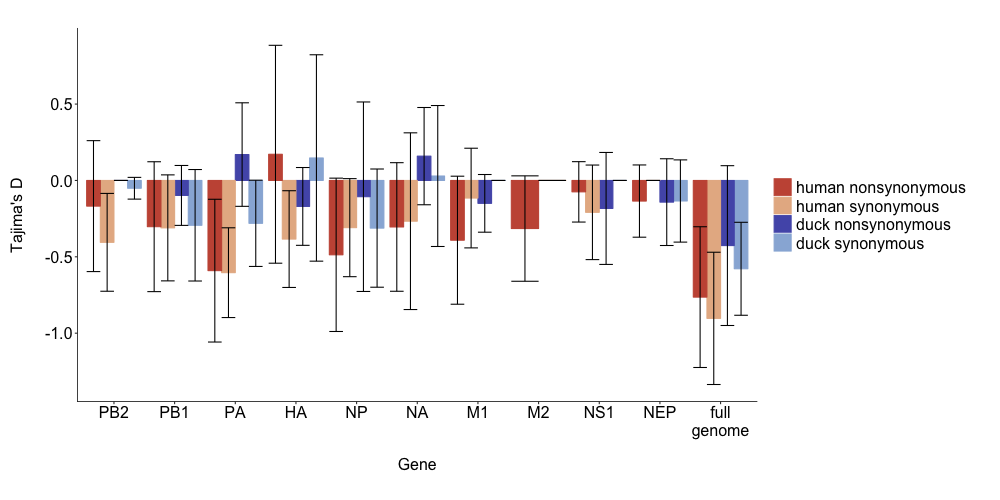

In [45]:
%%R -w 1000 -h 500 -u px -i  Tajimas_D_means_df,human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)

# this block of code is to ensure that even genes without SNPs get plotted so that the bars are all the same size
species_list = unique(Tajimas_D_means_df$species)
gene_list = unique(Tajimas_D_means_df$gene)
variables_list = unique(Tajimas_D_means_df$value)

# for (species in species_list)
# {
#     for (gene in gene_list)
#     {
#         for (variable in variables_list)
#         {
#             x = Tajimas_D_means_df[Tajimas_D_means_df$species == species & Tajimas_D_means_df$gene == gene & Tajimas_D_means_df$value == variable,]
#             if (nrow(x) == 0){
#                 mean_Tajimas_D = 0
#                 std = 0
#                 if (variable == "D_NS"){
#                     color = paste(species, " D_NS")
#                 } else{
#                     color = paste(species, " D_S")
#                 }
#                 row_to_append = data.frame(gene, species, variable, mean_Tajimas_D, color)
#                 d = rbind(df, row_to_append)
#             }
#         }
#     }
# }

Tajimas_D_means_df$gene = gsub("neuraminidase","NA", Tajimas_D_means_df$gene)
Tajimas_D_means_df$colorf = factor(Tajimas_D_means_df$color, levels=c("human D_NS","human D_S","duck D_NS","duck D_S"))
Tajimas_D_means_df$genef = factor(Tajimas_D_means_df$gene, levels=c('PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP','full\ngenome'))

p1 <- ggplot(data=Tajimas_D_means_df, aes(x=genef, y=mean_Tajimas_D, color=colorf, fill=colorf)) +
    geom_col(position="dodge")+   
    geom_errorbar(data=Tajimas_D_means_df, aes(x=genef, ymin=mean_Tajimas_D-std_Tajimas_D, ymax=mean_Tajimas_D+std_Tajimas_D), position="dodge", color="black")+
    labs(x="\nGene",y="Tajima's D")+
    scale_color_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human D_NS","human D_S","duck D_NS","duck D_S"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    scale_fill_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human D_NS","human D_S","duck D_NS","duck D_S"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    #ggtitle("random tables simulation") + 
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #facet_wrap(~genef, scales="free")+
    #scale_y_continuous(limits=c(-0.0012,0.0012))+
    theme(strip.text = element_text(size=16))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.65, "cm"))+
    #theme(legend.key=element_rect(fill=NA,size = 2))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("Fig-2b-Tajimas-D-stdev-2019-09-19.pdf", p1, width = 14, height = 6, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/Plos-Pathogens/resubmission/individual-PDFs/")
p1

## Bootstrap Tajima's D estimates

In [46]:
def fill_in_missing_values(D_values,sampling_value):
    D_values = list(np.nan_to_num(D_values))
    missing_values = sampling_value - len(D_values)
    for i in range(missing_values):
        D_values.append(0.0)
    return(D_values)

In [47]:
def bootrap_D_values(D_values, iterations, sampling_value):
    bootstrapped_means = []
    
    for i in range(iterations):
        sample = np.random.choice(D_values, sampling_value, replace=True)
        mean = np.asarray(sample).mean()
        bootstrapped_means.append(mean)
    
    bootstrapped_means_array = np.array(bootstrapped_means)
    a = np.quantile(bootstrapped_means_array, 0.975)
    b = np.quantile(bootstrapped_means_array, 0.025)
    c = np.std(bootstrapped_means_array)
    
    return(a,b,c)

In [48]:
# reformat dataframe for bootstrapping
D_bootstrap_df = Tajimas_D[["sample",'gene','D_NS',"D_S","species"]]
D_bootstrap_df.head()

,sample,gene,D_NS,D_S,species
0,A/CAMBODIA/V0401301/2011,HA,-1.022031,-0.642277,human
1,A/CAMBODIA/V0401301/2011,M1,-0.938281,NaN,human
2,A/CAMBODIA/V0401301/2011,NP,-1.103313,-0.867576,human
3,A/CAMBODIA/V0401301/2011,PA,-1.088153,-0.417521,human
4,A/CAMBODIA/V0401301/2011,PB1,-0.238081,-0.539702,human


In [51]:
iterations = 10000
sampling_values = {"human":8, "duck":5}
df2 = pd.DataFrame()

for species in set(D_bootstrap_df['species'].tolist()):
    
    for gene in set(D_bootstrap_df['gene'].tolist()):
        for D in ["D_NS","D_S"]:
            # add in exception for PB1, since we are missing 1 PB1 sequence 
            if gene == "PB1" and species == "human":
                sampling_value = 7
            else: 
                sampling_value = sampling_values[species]
            
            d = D_bootstrap_df[(D_bootstrap_df['gene'] == gene) & (D_bootstrap_df['species'] == species)]
            values = d[D].tolist()
            
            D_values = fill_in_missing_values(values,sampling_value)
            mean = np.asarray(D_values).mean()
            a,b,c = bootrap_D_values(D_values, iterations, sampling_value)
            
            # generate dataframe 
            x = pd.DataFrame({"species":[species],"gene":[gene],"variable":[D],"mean":[mean],
                            "bootstrap_lower":[b],"bootstrap_upper":[a],"se_mean":[c]})
            df2 = df2.append(x)

In [52]:
df2.head()

,species,gene,variable,mean,bootstrap_lower,bootstrap_upper,se_mean
0,duck,neuraminidase,D_NS,0.159209,0.000000,0.477628,0.141839
0,duck,neuraminidase,D_S,0.029068,-0.392879,0.480084,0.205626
0,duck,PB1,D_NS,-0.098073,-0.294219,0.000000,0.088570
0,duck,PB1,D_S,-0.293501,-0.626830,0.000000,0.163117
0,duck,M2,D_NS,0.000000,0.000000,0.000000,0.000000


In [53]:
df2['color'] = df2['species'] + " " + df2['variable']
df2

,species,gene,variable,mean,bootstrap_lower,bootstrap_upper,se_mean,color
0,duck,neuraminidase,D_NS,0.159209,0.000000,0.477628,0.141839,duck D_NS
0,duck,neuraminidase,D_S,0.029068,-0.392879,0.480084,0.205626,duck D_S
0,duck,PB1,D_NS,-0.098073,-0.294219,0.000000,0.088570,duck D_NS
0,duck,PB1,D_S,-0.293501,-0.626830,0.000000,0.163117,duck D_S
0,duck,M2,D_NS,0.000000,0.000000,0.000000,0.000000,duck D_NS
0,duck,M2,D_S,0.000000,0.000000,0.000000,0.000000,duck D_S
0,duck,NS1,D_NS,-0.183274,-0.549822,0.000000,0.160412,duck D_NS
0,duck,NS1,D_S,0.000000,0.000000,0.000000,0.000000,duck D_S
0,duck,M1,D_NS,-0.149963,-0.327676,0.000000,0.083942,duck D_NS
0,duck,M1,D_S,0.000000,0.000000,0.000000,0.000000,duck D_S


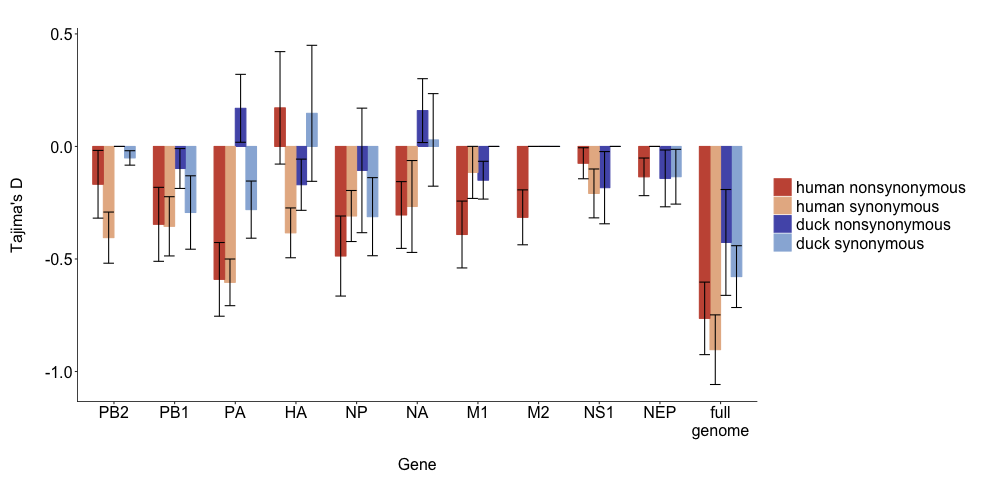

In [57]:
%%R -w 1000 -h 500 -u px -i  df2,human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)


# this block of code is to ensure that even genes without SNPs get plotted so that the bars are all the same size
species_list = unique(df2$species)
gene_list = unique(df2$gene)
variables_list = unique(df2$value)

for (species in species_list)
{
    for (gene in gene_list)
    {
        for (variable in variables_list)
        {
            x = df2[df2$species == species & df2$gene == gene & df2$value == variable,]
            if (nrow(x) == 0){
                mean = 0
                std = 0
                if (variable == "D_NS"){
                    color = paste(species, " D_NS")
                } else{
                    color = paste(species, " D_S")
                }
                row_to_append = data.frame(gene, species, variable, mean, std, color)
                d = rbind(df, row_to_append)
            }
        }
    }
}

df2$gene = gsub("neuraminidase","NA", df2$gene)
df2$colorf = factor(df2$color, levels=c("human D_NS","human D_S","duck D_NS","duck D_S"))
df2$genef = factor(df2$gene, levels=c('PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP','full\ngenome'))

p2 <- ggplot(data=df2, aes(x=genef, y=mean, color=colorf, fill=colorf, width=0.7)) +
    geom_col(position="dodge")+   
    geom_errorbar(data=df2, aes(x=genef, ymin=mean-se_mean, ymax=mean+se_mean), position="dodge", color="black")+
    labs(x="\nGene",y="Tajima's D")+
    scale_color_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human D_NS","human D_S","duck D_NS","duck D_S"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    scale_fill_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human D_NS","human D_S","duck D_NS","duck D_S"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    #ggtitle("random tables simulation") + 
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #facet_wrap(~genef, scales="free")+
    #scale_y_continuous(limits=c(-0.0012,0.0012))+
    theme(strip.text = element_text(size=16))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.65, "cm"))+
    #theme(legend.key=element_rect(fill=NA,size = 2))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("Fig-2b-Tajimas-D-bootstrap-2019-09-19.pdf", p2, width = 14, height = 6, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/Plos-Pathogens/resubmission/individual-PDFs/")
p2